In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%cd ..

/home/ubuntu/sustaingym


In [2]:
from copy import deepcopy
import matplotlib.pyplot as plt
import numpy as np
from stable_baselines3 import PPO

from sustaingym.envs.evcharging import GMMsTraceGenerator, EVChargingEnv, RealTraceGenerator
from sustaingym.envs.evcharging import RLAlgorithm, GreedyAlgorithm
from sustaingym.envs.evcharging.base_algorithm import BaseOnlineAlgorithm

In [4]:
gmm = GMMsTraceGenerator('caltech', 'Summer 2019')
env = EVChargingEnv(gmm, 'discrete')



AttributeError: 'GMMsTraceGenerator' object has no attribute 'recompute_freq'

In [ ]:
PATH_FORMAT = 'logs/exp_{num}/eval_on_eval_projected/best_model.zip'
num = 1

model = PPO.load(PATH_FORMAT.format(num=num))
rl_algorithm = RLAlgorithm(model, 'stepper')
# rl_algorithm.get_action()

In [14]:
evse_idx = env.evse_name_to_idx

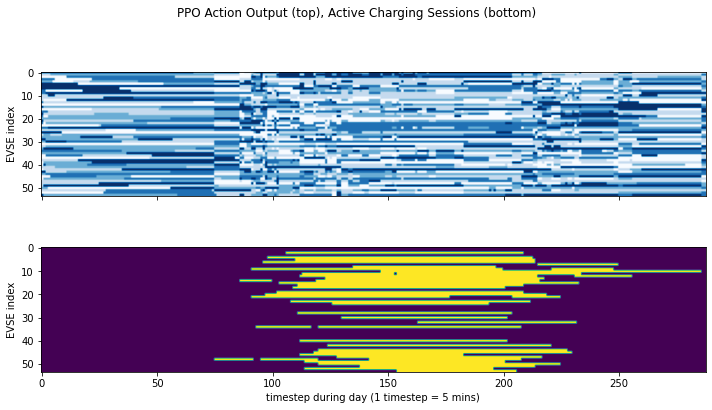

In [23]:
def actions_over_episode(env: EVChargingEnv, algorithm: BaseOnlineAlgorithm, seed: int):
    observation = env.reset()

    # build arrival-departure matrix
    ad = [(evse_idx[ev.station_id], ev.arrival, ev.departure) for ev in env.evs]
    ad_mat = np.zeros(shape=(54, 288))
    for station, a, d in ad:
        ad_mat[station, a:d] = 1

    actions, rewards = [], 0

    done = False
    while not done:
        algorithm.get_action(observation, env)
        action = model.predict(observation, deterministic=True)[0]
        observation, reward, done, _ = env.step(action)
        actions.append(action)
        rewards += reward
    
    return np.array(actions).T, ad_mat, rewards

actions, ad_mat, rewards = actions_over_episode(env, rl_algorithm, seed=42)
fig, ax = plt.subplots(2, 1, figsize=(10, 6), sharex=True)
ax[0].imshow(actions, cmap='Blues')
ax[1].imshow(ad_mat)
ax[1].set_xlabel('timestep during day (1 timestep = 5 mins)')
ax[0].set_ylabel('EVSE index')
ax[1].set_ylabel('EVSE index')
fig.suptitle('PPO Action Output (top), Active Charging Sessions (bottom)')
plt.tight_layout()
plt.show()